In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from utils import print_log

In [2]:
expt_datetime_dict = {
    ("discrete", "0.0"): datetime(2025, 8, 13, 23, 23, 31),
    ("discrete", "0.5"): datetime(2025, 8, 14, 2, 5, 26),
    ("discrete", "1.0"): datetime(2025, 8, 14, 4, 46, 19),
    ("continuous", "0.0"): datetime(2025, 8, 11, 2, 46, 31),
    ("continuous", "0.5"): datetime(2025, 8, 11, 4, 45, 55),
    ("continuous", "1.0"): datetime(2025, 8, 11, 6, 42, 39),
}

In [3]:
expt_folders = {
    k: Path("experiments") / (v.strftime("%Y%m%d_%H%M%S") + "_action_" + k[0] + "_reward_lambda_" + k[1]) for k, v in expt_datetime_dict.items()
}

# check if all folders exist
for folder in expt_folders.values():
    if not folder.exists():
        print_log(f"Experiment folder {folder} does not exist. Please check the experiment datetime and action type.")
        raise FileNotFoundError(f"Experiment folder {folder} does not exist.")
    else:
        print_log(f"Experiment folder {folder} exists.")
    
expt_train_folders = {
    k: v / ("logs_train") for k, v in expt_folders.items()
}

[2025-08-25 18:51:18:861] Experiment folder experiments/20250813_232331_action_discrete_reward_lambda_0.0 exists.
[2025-08-25 18:51:18:861] Experiment folder experiments/20250814_020526_action_discrete_reward_lambda_0.5 exists.
[2025-08-25 18:51:18:861] Experiment folder experiments/20250814_044619_action_discrete_reward_lambda_1.0 exists.
[2025-08-25 18:51:18:861] Experiment folder experiments/20250811_024631_action_continuous_reward_lambda_0.0 exists.
[2025-08-25 18:51:18:861] Experiment folder experiments/20250811_044555_action_continuous_reward_lambda_0.5 exists.
[2025-08-25 18:51:18:861] Experiment folder experiments/20250811_064239_action_continuous_reward_lambda_1.0 exists.


In [4]:
output_folder = Path("experiments_graphs")

if not output_folder.exists():
    output_folder.mkdir(parents=True)

We now compare the overall MI achieved from both models

This can be done by plotting a distribution of the MI across the training phrase

In [5]:
def load_all_training_MI(expt_train_folders):
    """
    Load MI on training data from all experiment training folders.
    
    Args:
        expt_train_folders: dict with keys (action_space, lambda_value) and values as Path objects
                           to training folders containing mutual_information_per_episode.pkl files

    Returns:
        dict: Same keys as input, values are DataFrames containing MI on training data
    """

    all_results = {}
    
    for key, expt_train_folder in expt_train_folders.items():
        print_log(f"Loading MI on training data for experiment {key}: {expt_train_folder}")

        # Load MI on training data
        mi_on_training_data_path = expt_train_folder / "graphs" / "per_episode_psd" / "mutual_information_per_episode.pkl"

        if mi_on_training_data_path.exists():
            with open(mi_on_training_data_path, "rb") as f:
                mi_on_training_data_df = pd.read_pickle(f)
                print_log(f"Loaded MI on training data for {key}: {len(mi_on_training_data_df)} training steps")
                print_log(f"MI on training data DataFrame shape for {key}: {mi_on_training_data_df.shape}")
                all_results[key] = mi_on_training_data_df
        else:
            print_log(f"MI on training data file {mi_on_training_data_path} does not exist for {key}.")
            all_results[key] = None
    
    return all_results

In [6]:
# Load all MI training data from experiment folders
all_training_MI = load_all_training_MI(expt_train_folders)

# Display summary of loaded data
for key, mi_on_training_data_df in all_training_MI.items():
    if mi_on_training_data_df is not None:
        print_log(f"Experiment {key}: {len(mi_on_training_data_df)} training steps loaded")
        if len(mi_on_training_data_df) > 0:
            print_log(f"  Columns: {list(mi_on_training_data_df.columns)}")
            print_log(f"  Training steps range: {mi_on_training_data_df.index.min()} to {mi_on_training_data_df.index.max()}")
    else:
        print_log(f"Experiment {key}: No MI on training data found")

[2025-08-25 18:51:18:877] Loading MI on training data for experiment ('discrete', '0.0'): experiments/20250813_232331_action_discrete_reward_lambda_0.0/logs_train
[2025-08-25 18:51:18:878] Loaded MI on training data for ('discrete', '0.0'): 805 training steps
[2025-08-25 18:51:18:878] MI on training data DataFrame shape for ('discrete', '0.0'): (805, 5)
[2025-08-25 18:51:18:878] Loading MI on training data for experiment ('discrete', '0.5'): experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train
[2025-08-25 18:51:18:879] Loaded MI on training data for ('discrete', '0.5'): 805 training steps
[2025-08-25 18:51:18:879] MI on training data DataFrame shape for ('discrete', '0.5'): (805, 5)
[2025-08-25 18:51:18:879] Loading MI on training data for experiment ('discrete', '1.0'): experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train
[2025-08-25 18:51:18:880] Loaded MI on training data for ('discrete', '1.0'): 805 training steps
[2025-08-25 18:51:18:880] MI

In [7]:
def plot_cross_model_mi_distributions(all_training_MI, show=True, save_path=None):
    """
    Plots mutual information distribution curves for all models using probability density estimation.
    
    Args:
        all_training_MI: dict with keys (action_space, lambda_value) and values as DataFrames containing MI data
        show: bool, whether to show plot (default: True)
        save_path: str or None, path to save figure (default: None)
    """
    
    # Extract MI data for each experiment
    model_mi_dict = {}
    
    for key, mi_df in all_training_MI.items():
        if mi_df is not None and len(mi_df) > 0:
            action_space, lambda_value = key
            
            # Extract MI values - assuming the MI column exists
            mi_columns = [col for col in mi_df.columns if 'mi' in col.lower() or 'mutual' in col.lower()]
            
            if mi_columns:
                # Use the first MI column found
                mi_column = mi_columns[0]
                mi_values = mi_df[mi_column].dropna().values
                
                if len(mi_values) > 0:
                    # Map action space to algorithm name
                    algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
                    model_mi_dict[key] = {
                        'mi_values': mi_values,
                        'label': f'{algo_name} λ={lambda_value}'
                    }
                    print_log(f"Loaded MI data for {key}: {len(mi_values)} values, mean={np.mean(mi_values):.4f}")
    
    if not model_mi_dict:
        print_log("No valid MI data found for plotting.")
        return None
    
    # Assign colors for each lambda value using tab10 palette (consistent with h-network plots)
    unique_lambdas = sorted(set([k[1] for k in model_mi_dict.keys()]))
    base_palette = sns.color_palette('tab10', n_colors=len(unique_lambdas))
    lambda_color_map = {lam: base_palette[i] for i, lam in enumerate(unique_lambdas)}
    
    # For each lambda, create saturated (continuous) and pale (discrete) variants
    def adjust_color(color, saturation):
        # Simple saturation adjustment: interpolate towards white
        return tuple([saturation * c + (1-saturation) * 1.0 for c in color])
    
    action_space_saturation = {'continuous': 1.0, 'discrete': 0.5}
    
    # Create the plot
    plt.figure(figsize=(12, 7), dpi=150)
    
    # Plot probability density curves for each model
    for (action_space, lambda_value), result in model_mi_dict.items():
        mi_values = result['mi_values']
        label = result['label']
        
        color_base = lambda_color_map[lambda_value]
        color = adjust_color(color_base, action_space_saturation[action_space])
        
        # Plot probability density curve using seaborn's kdeplot
        sns.kdeplot(data=mi_values, color=color, linewidth=2, label=label, alpha=0.8)
    
    plt.xlabel('Mutual Information (bits)')
    plt.ylabel('Probability Density')
    plt.title('Cross-Model Mutual Information Distribution')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print_log(f"MI distribution plot saved to: {save_path}")
    
    if show:
        plt.show()
    
    # Print summary statistics
    print_log("\nMutual Information Distribution Summary:")
    for (action_space, lambda_value), result in model_mi_dict.items():
        mi_values = result['mi_values']
        mean_mi = np.mean(mi_values)
        std_mi = np.std(mi_values)
        median_mi = np.median(mi_values)
        min_mi = np.min(mi_values)
        max_mi = np.max(mi_values)
        
        algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
        print_log(f"{algo_name} λ={lambda_value}: {len(mi_values)} samples")
        print_log(f"  Mean: {mean_mi:.4f}, Std: {std_mi:.4f}, Median: {median_mi:.4f}")
        print_log(f"  Range: [{min_mi:.4f}, {max_mi:.4f}]")
    
    return plt.gcf()

[2025-08-25 18:51:18:899] Loaded MI data for ('discrete', '0.0'): 805 values, mean=0.9518
[2025-08-25 18:51:18:899] Loaded MI data for ('discrete', '0.5'): 805 values, mean=0.9529
[2025-08-25 18:51:18:900] Loaded MI data for ('discrete', '1.0'): 805 values, mean=0.8995
[2025-08-25 18:51:18:900] Loaded MI data for ('continuous', '0.0'): 807 values, mean=0.3037
[2025-08-25 18:51:18:900] Loaded MI data for ('continuous', '0.5'): 807 values, mean=0.2931
[2025-08-25 18:51:18:900] Loaded MI data for ('continuous', '1.0'): 807 values, mean=3.7293
[2025-08-25 18:51:19:069] MI distribution plot saved to: experiments_graphs/cross_model_mi_distributions.svg


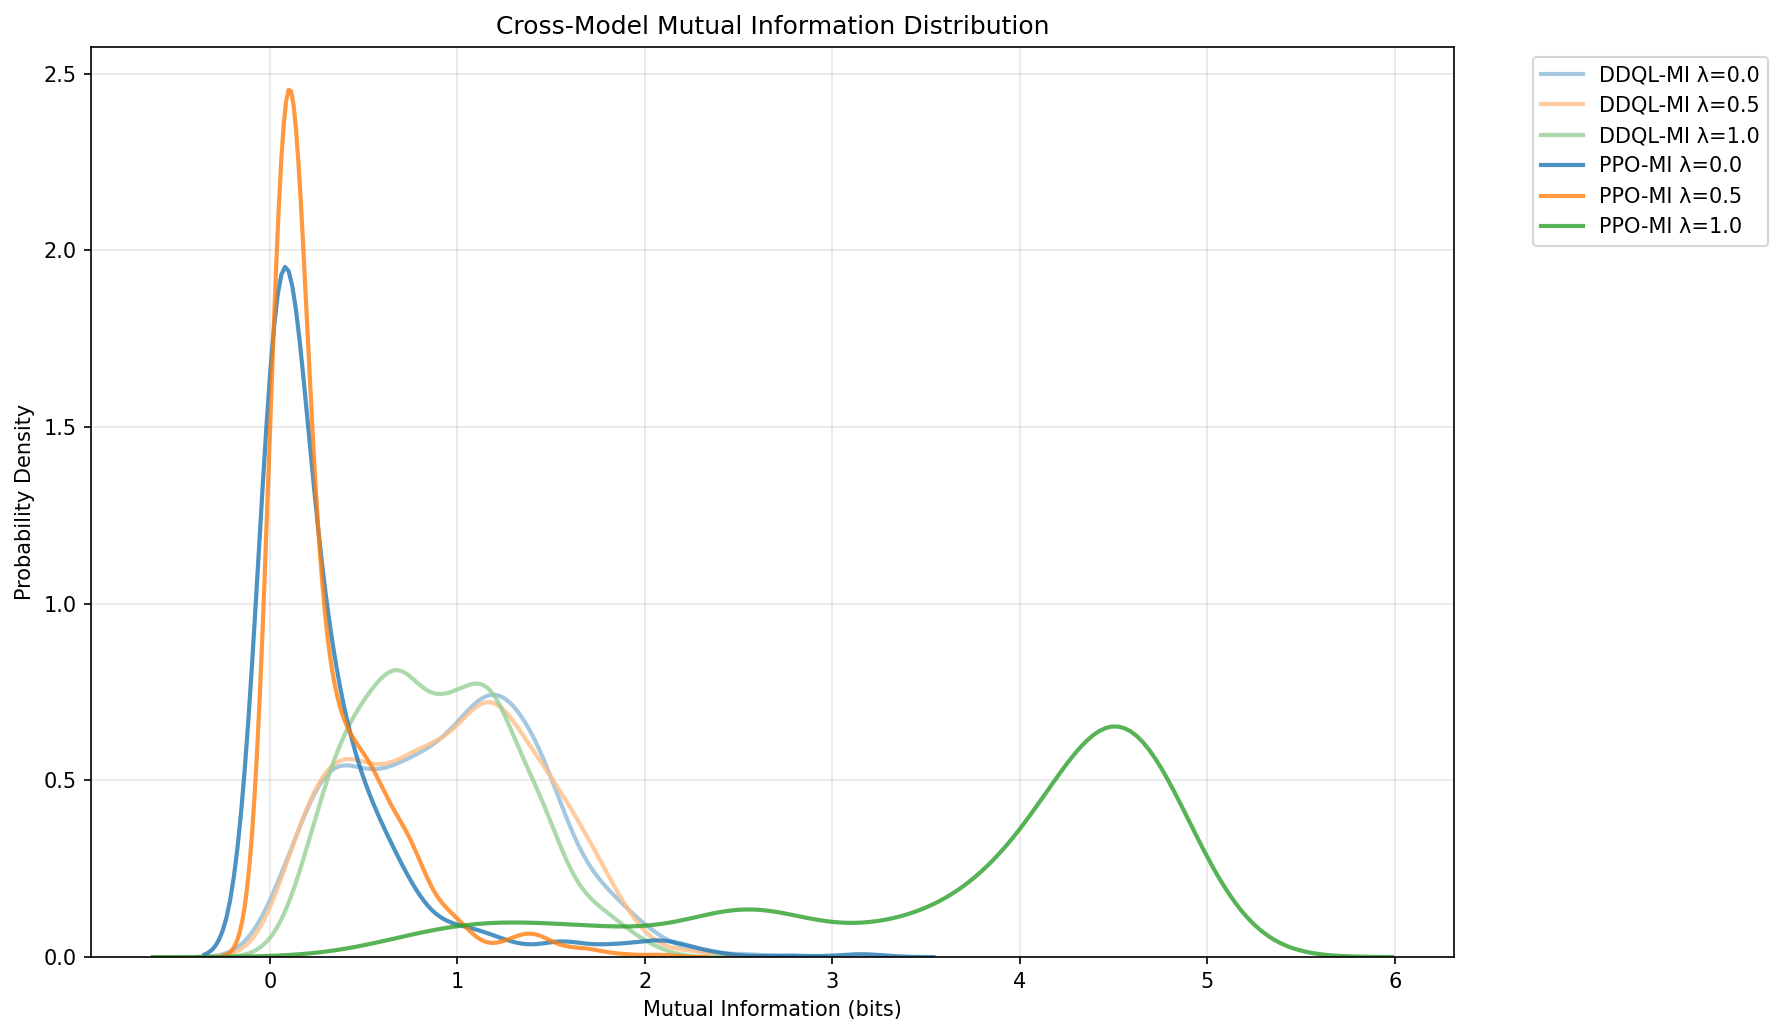

[2025-08-25 18:51:19:170] 
Mutual Information Distribution Summary:
[2025-08-25 18:51:19:171] DDQL-MI λ=0.0: 805 samples
[2025-08-25 18:51:19:172]   Mean: 0.9518, Std: 0.4966, Median: 0.9840
[2025-08-25 18:51:19:172]   Range: [0.0000, 2.5656]
[2025-08-25 18:51:19:172] DDQL-MI λ=0.5: 805 samples
[2025-08-25 18:51:19:172]   Mean: 0.9529, Std: 0.4888, Median: 0.9764
[2025-08-25 18:51:19:172]   Range: [0.0000, 2.2628]
[2025-08-25 18:51:19:172] DDQL-MI λ=1.0: 805 samples
[2025-08-25 18:51:19:172]   Mean: 0.8995, Std: 0.4182, Median: 0.8831
[2025-08-25 18:51:19:172]   Range: [0.0217, 2.0922]
[2025-08-25 18:51:19:172] PPO-MI λ=0.0: 807 samples
[2025-08-25 18:51:19:172]   Mean: 0.3037, Std: 0.4445, Median: 0.1342
[2025-08-25 18:51:19:172]   Range: [0.0000, 3.1900]
[2025-08-25 18:51:19:172] PPO-MI λ=0.5: 807 samples
[2025-08-25 18:51:19:172]   Mean: 0.2931, Std: 0.3188, Median: 0.1581
[2025-08-25 18:51:19:172]   Range: [0.0000, 2.0775]
[2025-08-25 18:51:19:172] PPO-MI λ=1.0: 807 samples
[2025-0

<Figure size 640x480 with 0 Axes>

In [8]:
# Test the cross-model MI distribution plot
fig_mi_dist = plot_cross_model_mi_distributions(
    all_training_MI, 
    show=True, 
    save_path=output_folder / "cross_model_mi_distributions.svg"
)

We also plot the distribution of the extra cost incurred from these models.

In [9]:
def load_all_training_extra_cost(expt_train_folders):
    """
    Load extra cost on training data from all experiment training folders.

    Args:
        expt_train_folders: dict with keys (action_space, lambda_value) and values as Path objects
                           to training folders containing extra_cost_per_episode.pkl files

    Returns:
        dict: Same keys as input, values are DataFrames containing extra cost on training data
    """

    all_results = {}
    
    for key, expt_train_folder in expt_train_folders.items():
        print_log(f"Loading MI on training data for experiment {key}: {expt_train_folder}")

        # Load MI on training data
        extra_cost_on_training_data_path = expt_train_folder / "graphs" / "per_episode_psd" / "extra_cost_per_episode.pkl"

        if extra_cost_on_training_data_path.exists():
            with open(extra_cost_on_training_data_path, "rb") as f:
                extra_cost_on_training_data_df = pd.read_pickle(f)
                print_log(f"Loaded extra cost on training data for {key}: {len(extra_cost_on_training_data_df)} training steps")
                print_log(f"Extra cost on training data DataFrame shape for {key}: {extra_cost_on_training_data_df.shape}")
                all_results[key] = extra_cost_on_training_data_df
        else:
            print_log(f"Extra cost on training data file {extra_cost_on_training_data_path} does not exist for {key}.")
            all_results[key] = None
    
    return all_results

In [10]:
# Load all extra cost data from experiment folders
all_training_extra_cost = load_all_training_extra_cost(expt_train_folders)

# Display summary of loaded data
for key, extra_cost_on_training_data_df in all_training_extra_cost.items():
    if extra_cost_on_training_data_df is not None:
        print_log(f"Experiment {key}: {len(extra_cost_on_training_data_df)} training steps loaded")
        if len(extra_cost_on_training_data_df) > 0:
            print_log(f"  Columns: {list(extra_cost_on_training_data_df.columns)}")
            print_log(f"  Training steps range: {extra_cost_on_training_data_df.index.min()} to {extra_cost_on_training_data_df.index.max()}")
    else:
        print_log(f"Experiment {key}: No extra cost on training data found")

[2025-08-25 18:51:19:185] Loading MI on training data for experiment ('discrete', '0.0'): experiments/20250813_232331_action_discrete_reward_lambda_0.0/logs_train
[2025-08-25 18:51:19:186] Loaded extra cost on training data for ('discrete', '0.0'): 805 training steps
[2025-08-25 18:51:19:186] Extra cost on training data DataFrame shape for ('discrete', '0.0'): (805, 6)
[2025-08-25 18:51:19:186] Loading MI on training data for experiment ('discrete', '0.5'): experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train
[2025-08-25 18:51:19:187] Loaded extra cost on training data for ('discrete', '0.5'): 805 training steps
[2025-08-25 18:51:19:187] Extra cost on training data DataFrame shape for ('discrete', '0.5'): (805, 6)
[2025-08-25 18:51:19:187] Loading MI on training data for experiment ('discrete', '1.0'): experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train
[2025-08-25 18:51:19:188] Loaded extra cost on training data for ('discrete', '1.0'): 805 tra

In [11]:
def plot_cross_model_extra_cost_distributions(all_training_extra_cost, show=True, save_path=None):
    """
    Plots extra cost distribution curves for all models using probability density estimation.
    
    Args:
        all_training_extra_cost: dict with keys (action_space, lambda_value) and values as DataFrames containing extra cost data
        show: bool, whether to show plot (default: True)
        save_path: str or None, path to save figure (default: None)
    """
    
    # Extract extra cost data for each experiment
    model_extra_cost_dict = {}
    
    for key, extra_cost_df in all_training_extra_cost.items():
        if extra_cost_df is not None and len(extra_cost_df) > 0:
            action_space, lambda_value = key
            
            # Extract extra cost values - assuming the extra cost column exists
            cost_columns = [col for col in extra_cost_df.columns if 'cost' in col.lower() or 'extra' in col.lower()]
            
            if cost_columns:
                # Use the first extra cost column found
                cost_column = cost_columns[0]
                cost_values = extra_cost_df[cost_column].dropna().values
                
                if len(cost_values) > 0:
                    # Map action space to algorithm name
                    algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
                    model_extra_cost_dict[key] = {
                        'cost_values': cost_values,
                        'label': f'{algo_name} λ={lambda_value}'
                    }
                    print_log(f"Loaded extra cost data for {key}: {len(cost_values)} values, mean={np.mean(cost_values):.4f}")
    
    if not model_extra_cost_dict:
        print_log("No valid extra cost data found for plotting.")
        return None
    
    # Assign colors for each lambda value using tab10 palette (consistent with MI plots)
    unique_lambdas = sorted(set([k[1] for k in model_extra_cost_dict.keys()]))
    base_palette = sns.color_palette('tab10', n_colors=len(unique_lambdas))
    lambda_color_map = {lam: base_palette[i] for i, lam in enumerate(unique_lambdas)}
    
    # For each lambda, create saturated (continuous) and pale (discrete) variants
    def adjust_color(color, saturation):
        # Simple saturation adjustment: interpolate towards white
        return tuple([saturation * c + (1-saturation) * 1.0 for c in color])
    
    action_space_saturation = {'continuous': 1.0, 'discrete': 0.5}
    
    # Create the plot
    plt.figure(figsize=(12, 7), dpi=150)
    
    # Plot probability density curves for each model
    for (action_space, lambda_value), result in model_extra_cost_dict.items():
        cost_values = result['cost_values']
        label = result['label']
        
        color_base = lambda_color_map[lambda_value]
        color = adjust_color(color_base, action_space_saturation[action_space])
        
        # Plot probability density curve using seaborn's kdeplot
        sns.kdeplot(data=cost_values, color=color, linewidth=2, label=label, alpha=0.8)
    
    plt.xlabel('Extra Cost')
    plt.ylabel('Probability Density')
    plt.title('Cross-Model Extra Cost Distribution')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print_log(f"Extra cost distribution plot saved to: {save_path}")
    
    if show:
        plt.show()
    
    # Print summary statistics
    print_log("\nExtra Cost Distribution Summary:")
    for (action_space, lambda_value), result in model_extra_cost_dict.items():
        cost_values = result['cost_values']
        mean_cost = np.mean(cost_values)
        std_cost = np.std(cost_values)
        median_cost = np.median(cost_values)
        min_cost = np.min(cost_values)
        max_cost = np.max(cost_values)
        
        algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
        print_log(f"{algo_name} λ={lambda_value}: {len(cost_values)} samples")
        print_log(f"  Mean: {mean_cost:.4f}, Std: {std_cost:.4f}, Median: {median_cost:.4f}")
        print_log(f"  Range: [{min_cost:.4f}, {max_cost:.4f}]")
    
    return plt.gcf()

[2025-08-25 18:51:19:204] Loaded extra cost data for ('discrete', '0.0'): 805 values, mean=0.8739
[2025-08-25 18:51:19:204] Loaded extra cost data for ('discrete', '0.5'): 805 values, mean=0.9440
[2025-08-25 18:51:19:204] Loaded extra cost data for ('discrete', '1.0'): 805 values, mean=0.9279
[2025-08-25 18:51:19:205] Loaded extra cost data for ('continuous', '0.0'): 807 values, mean=0.8312
[2025-08-25 18:51:19:205] Loaded extra cost data for ('continuous', '0.5'): 807 values, mean=0.7707
[2025-08-25 18:51:19:205] Loaded extra cost data for ('continuous', '1.0'): 807 values, mean=0.9241
[2025-08-25 18:51:19:405] Extra cost distribution plot saved to: experiments_graphs/cross_model_extra_cost_distributions.svg


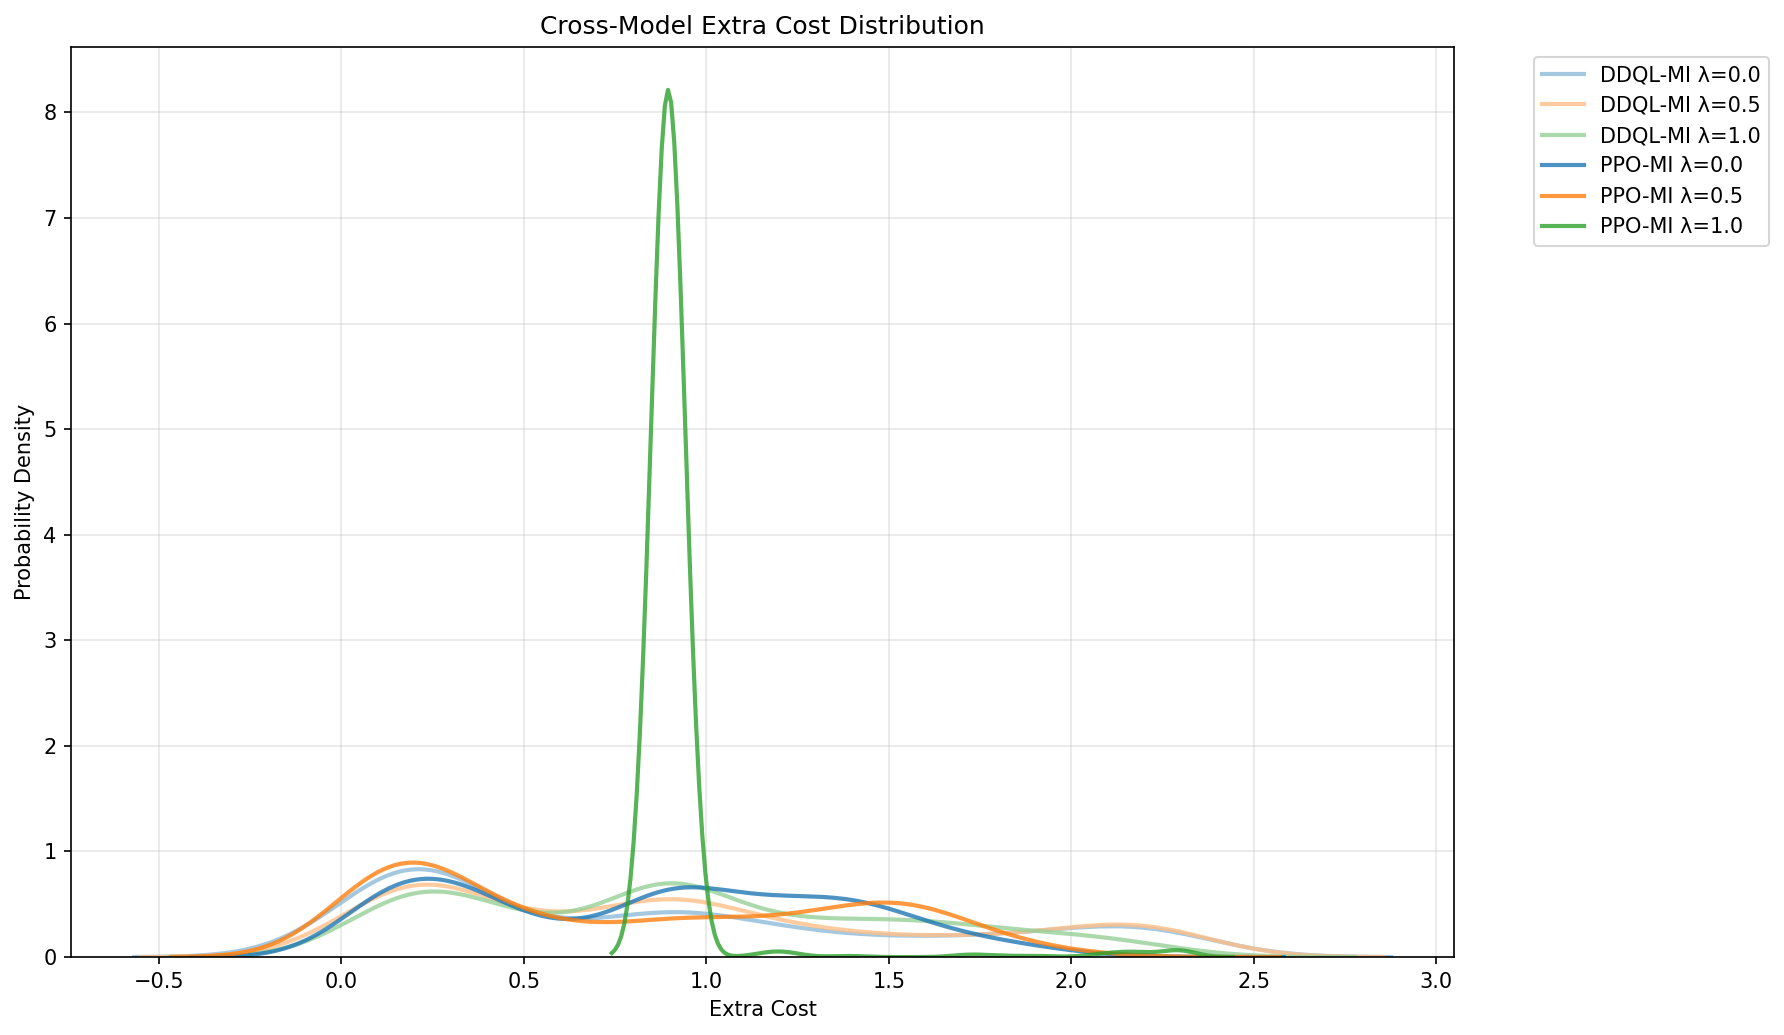

[2025-08-25 18:51:19:489] 
Extra Cost Distribution Summary:
[2025-08-25 18:51:19:490] DDQL-MI λ=0.0: 805 samples
[2025-08-25 18:51:19:490]   Mean: 0.8739, Std: 0.7261, Median: 0.7586
[2025-08-25 18:51:19:490]   Range: [0.0043, 2.3048]
[2025-08-25 18:51:19:490] DDQL-MI λ=0.5: 805 samples
[2025-08-25 18:51:19:490]   Mean: 0.9440, Std: 0.6993, Median: 0.8958
[2025-08-25 18:51:19:490]   Range: [0.0010, 2.3049]
[2025-08-25 18:51:19:490] DDQL-MI λ=1.0: 805 samples
[2025-08-25 18:51:19:490]   Mean: 0.9279, Std: 0.5989, Median: 0.8976
[2025-08-25 18:51:19:490]   Range: [0.0011, 2.3055]
[2025-08-25 18:51:19:490] PPO-MI λ=0.0: 807 samples
[2025-08-25 18:51:19:490]   Mean: 0.8312, Std: 0.5256, Median: 0.8935
[2025-08-25 18:51:19:490]   Range: [0.0011, 2.1684]
[2025-08-25 18:51:19:490] PPO-MI λ=0.5: 807 samples
[2025-08-25 18:51:19:490]   Mean: 0.7707, Std: 0.5909, Median: 0.6248
[2025-08-25 18:51:19:490]   Range: [0.0001, 2.1053]
[2025-08-25 18:51:19:490] PPO-MI λ=1.0: 807 samples
[2025-08-25 18:

<Figure size 640x480 with 0 Axes>

In [12]:
# Test the cross-model extra cost distribution plot
fig_extra_cost_dist = plot_cross_model_extra_cost_distributions(
    all_training_extra_cost, 
    show=True, 
    save_path=output_folder / "cross_model_extra_cost_distributions.svg"
)